<a href="https://www.kaggle.com/code/jlcordoba/birdclef-notebook-pplu?scriptVersionId=94510925" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
                                                                                # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
#reading CSV with pandas
Taxonomy = pd.read_csv('../input/birdclef-2022/eBird_Taxonomy_v2021.csv')
test = pd.read_csv('../input/birdclef-2022/test.csv')
train_metadata = pd.read_csv('../input/birdclef-2022/train_metadata.csv')
submission = pd.read_csv('../input/birdclef-2022/sample_submission.csv')
from os import path
from pydub import AudioSegment
import seaborn as sns

# files
src = "../input/birdclef-2022/train_audio/afrsil1/XC395771.ogg"#this audio have 4.5 rating
dst = "/kaggle/working/XC395771.wav"

# convert ogg to wav
sound = AudioSegment.from_ogg(src)
sound.export(dst, format="wav")

#transform into dataframe
df_taxonomy = pd.DataFrame(Taxonomy)

df_test = pd.DataFrame(test)

df_train = pd.DataFrame(train_metadata)

df_submission = pd.DataFrame(submission)

df_taxonomy.head()







# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN


In [2]:
df_test.head()

,row_id,file_id,bird,end_time
0,soundscape_1000170626_akiapo_5,soundscape_1000170626,akiapo,5
1,soundscape_1000170626_akiapo_10,soundscape_1000170626,akiapo,10
2,soundscape_1000170626_akiapo_15,soundscape_1000170626,akiapo,15


In [3]:
df_train.size

193076

In [4]:
df_train['primary_label']

0        afrsil1
1        afrsil1
2        afrsil1
3        afrsil1
4        afrsil1
          ...   
14847     zebdov
14848     zebdov
14849     zebdov
14850     zebdov
14851     zebdov
Name: primary_label, Length: 14852, dtype: object

In [5]:
df_train.columns
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [6]:
df_train['filename'][16]

'akekee/XC174953.ogg'

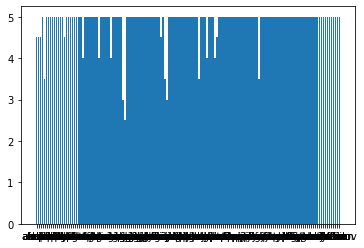

In [7]:
df_train['rating']
y_axis = df_train['rating']
x_axis = df_train['primary_label']
plt.bar(x_axis, y_axis)
plt.show()

In [8]:
df_submission.head()

,row_id,target
0,soundscape_1000170626_akiapo_5,False
1,soundscape_1000170626_akiapo_10,False
2,soundscape_1000170626_akiapo_15,False


In [9]:
#opening the scored bird file
with open('../input/birdclef-2022/scored_birds.json','r') as f:
    data = json.load(f)

In [10]:
print(data)

['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai', 'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar', 'warwhe1', 'yefcan']


In [11]:
sample_rate, samples = wavfile.read('/kaggle/working/XC395771.wav')


In [12]:
len(samples)

871744

In [13]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

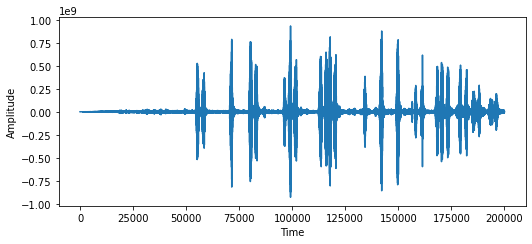

In [14]:
#Plotting Amplitude of a wav file against time
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
input_data = read("/kaggle/working/XC395771.wav")
audio = input_data[1]
plt.plot(audio[0:200000])#6seconds of video
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

hypothesis: we need to consider the distancies between peaks with aproximately the same amplitude but only the ones which are close to each other, for example, the first two peaks that can be seeing in the image above. I think one of the features can be the average speed at which the bird repeat the same frequency. It is easier to understand when you listen the first 6 second of the audio and see the image above at the same time.

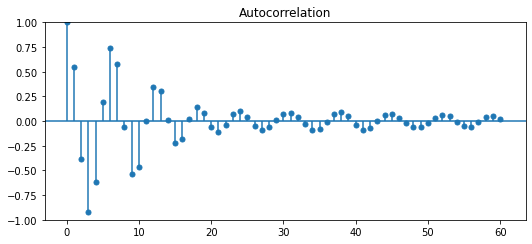

In [15]:
#Lets try to look for periodicity in this audio

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(audio)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

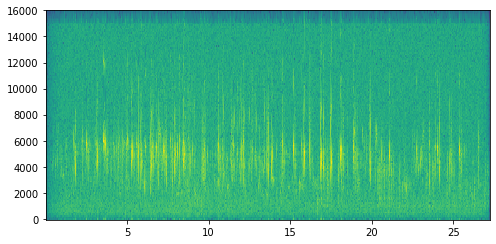

<Figure size 216x216 with 0 Axes>

In [16]:
#Creating an spectrogram of the same file
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sample_rate, samples = wavfile.read('/kaggle/working/XC395771.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram),shading = 'auto')
plt.figure(figsize = (3,3))

plt.show

In [17]:
#We calculate the discrete Fourier Transformation for our signal

fft_spectrum = np.fft.rfft(input_data[1])

In [18]:
fft_spectrum

array([ 14081006.               +0.j        ,
       -55112870.46310902+14860739.43745732j,
        -9218550.8361727  -8984545.7499299j , ...,
        -2780734.48171294  -372362.47420359j,
        -4229068.03072262   -24731.78713393j,
         2652726.               +0.j        ])

In [19]:
#range of frequencies
freq = np.fft.rfftfreq(input_data[1].size, d = 1./sample_rate)

In [20]:
fft_spectrum_abs = np.abs(fft_spectrum)

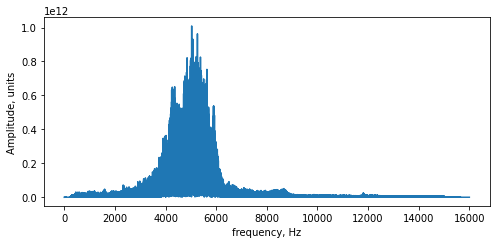

In [21]:
# we plot FFT
plt.plot(freq,fft_spectrum_abs)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

Hypothesis:  We may fit a gaussian here and get sigma values. Depending on the bird we may fit more than one gaussian and get more than one sigma value.

In [22]:
np.shape(spectrogram)

(129, 3891)

In [23]:
len(frequencies)

129

In [24]:
len(times)

3891

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


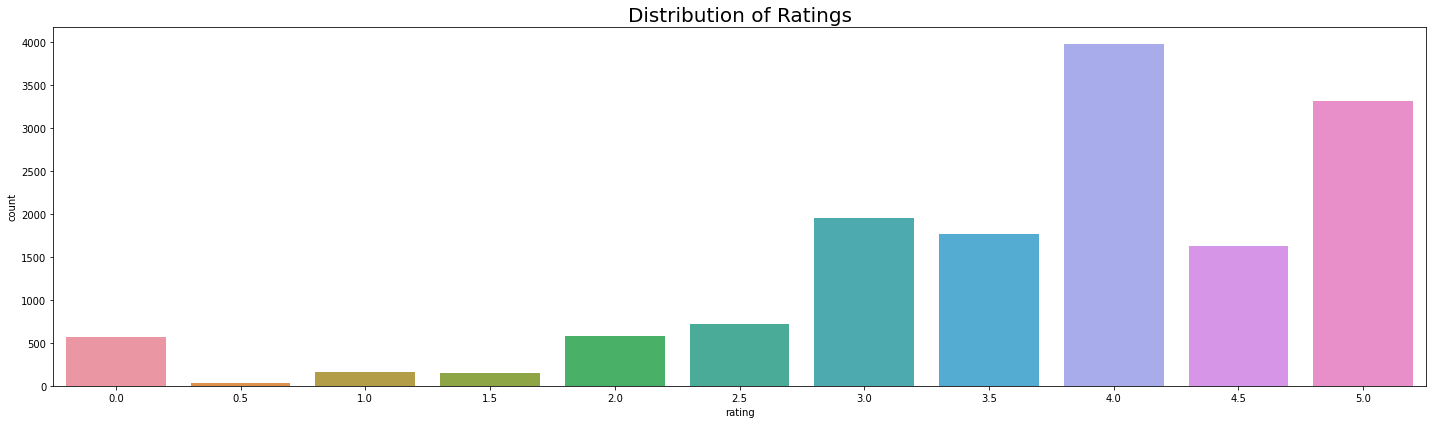

In [25]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['rating'])
plt.title("Distribution of Ratings", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show(close=None, block=None)>

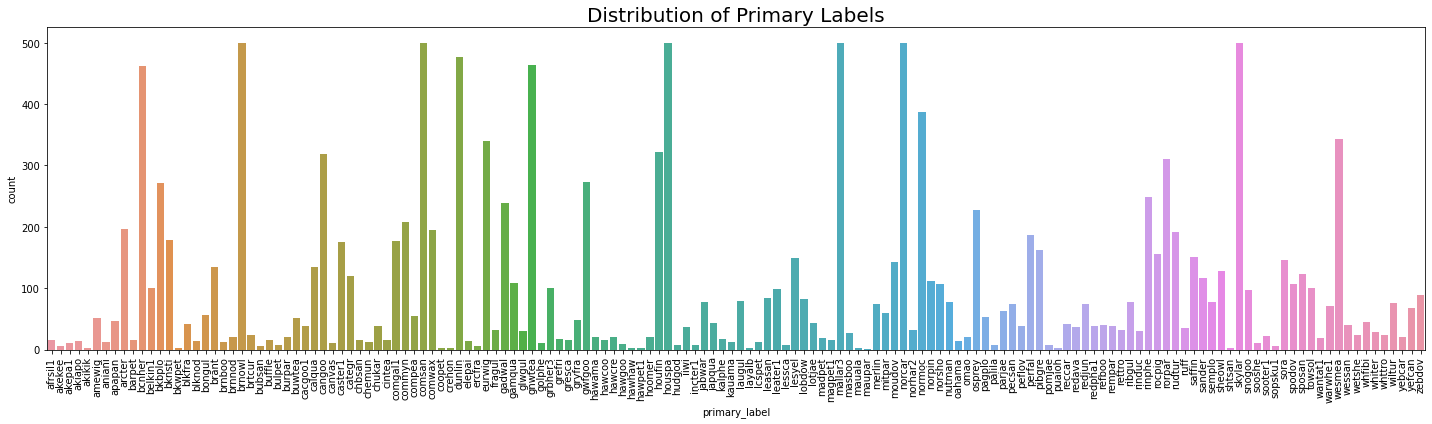

In [26]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['primary_label'])
plt.xticks(rotation=90)
plt.title("Distribution of Primary Labels", fontsize=20)

plt.show

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


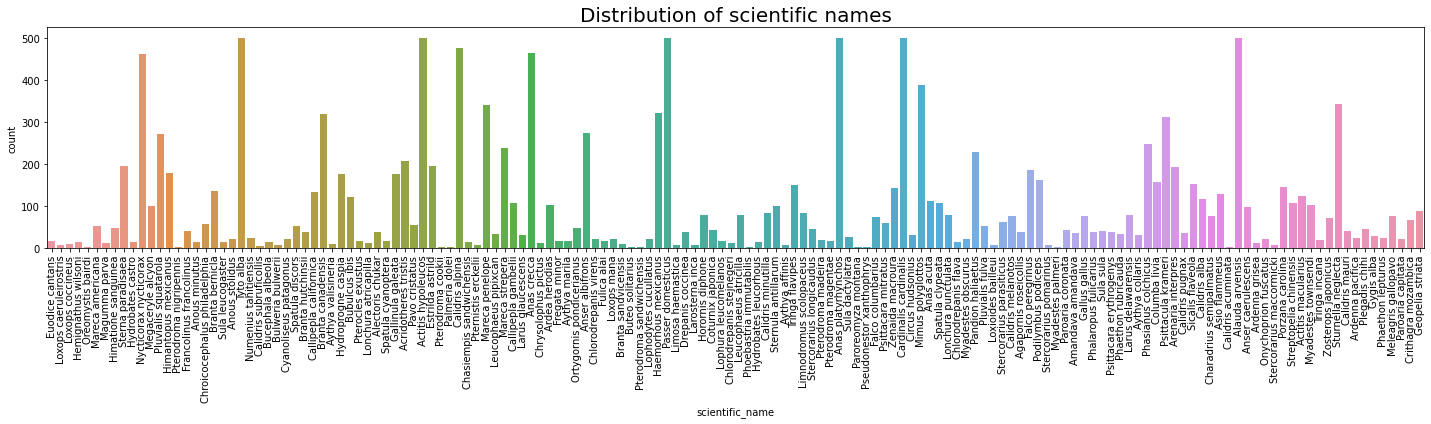

In [27]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['scientific_name'])
plt.xticks(rotation=90)
plt.title("Distribution of scientific names", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


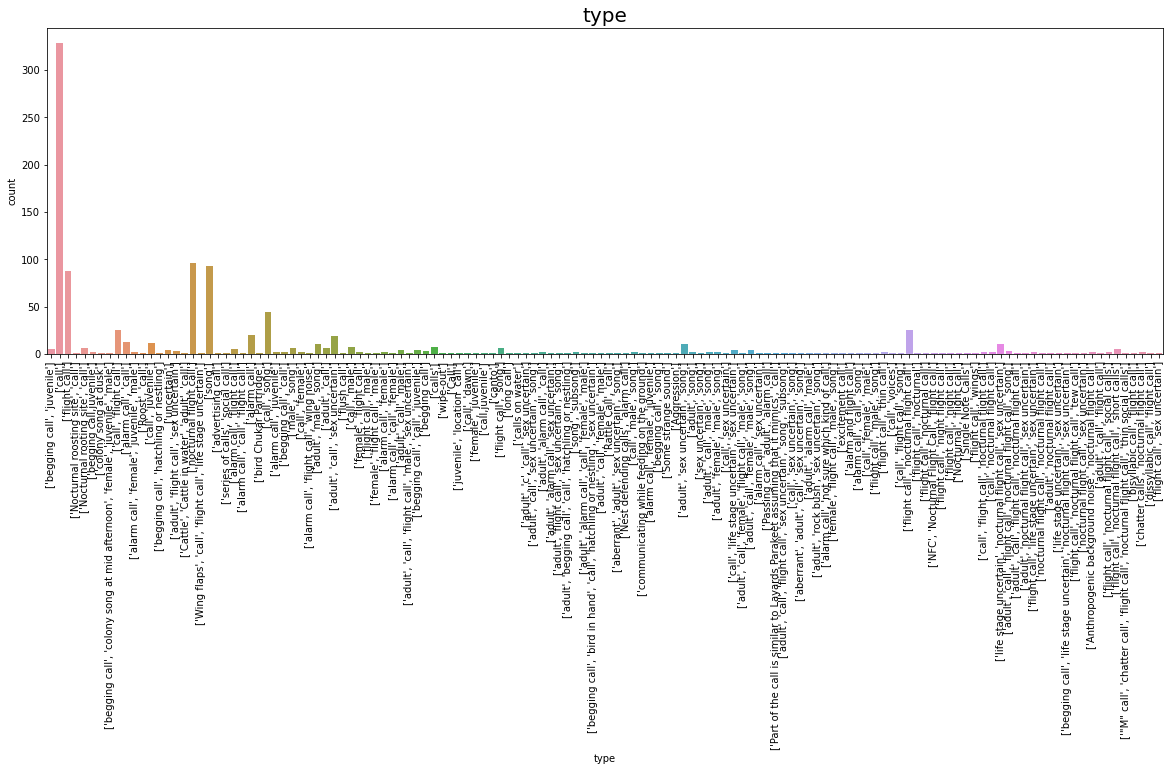

In [28]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['type'][3000:4000])
plt.xticks(rotation=90)
plt.title("type", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


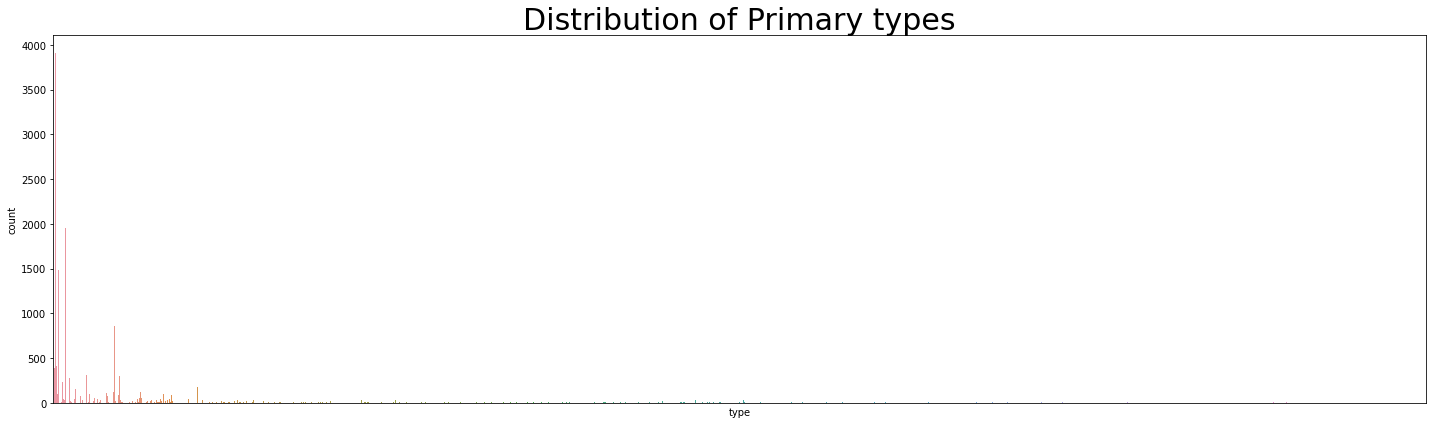

In [29]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['type'])
plt.title("Distribution of Primary types", fontsize=30)
plt.tick_params(axis = 'x', which = 'both', bottom = False,top = False, labelbottom = False )
plt.show()

In [30]:
#Elimino los elementos con un rating menor que 2.5, 
#lo que elimina tb los elementos que no tienen rating
#for i in df_train.index:
    #if df_train['rating'][i]<2.5:
       # df_train.drop([i],axis = 0, inplace = True)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


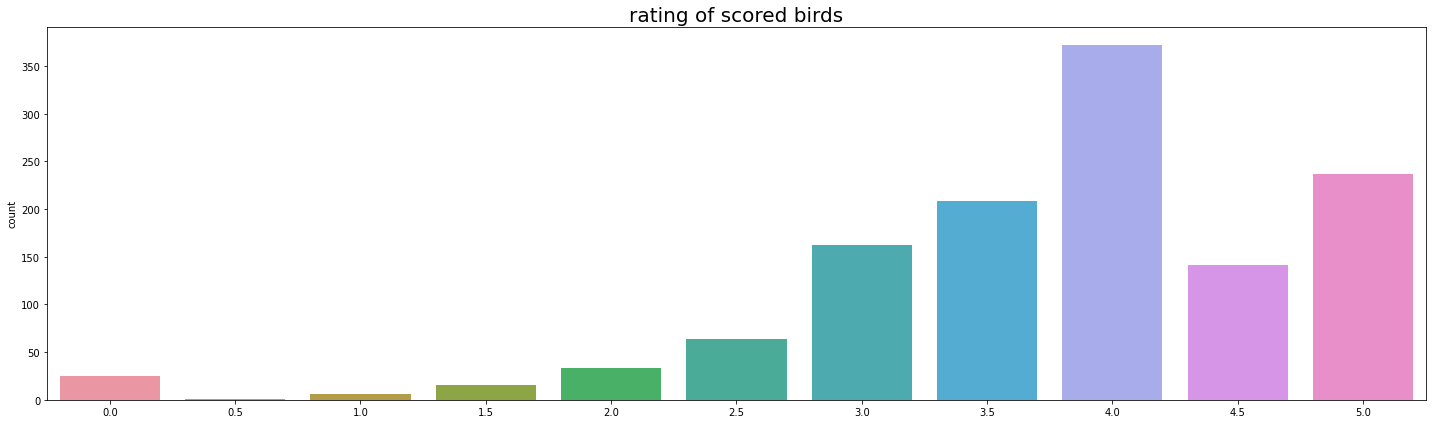

In [31]:
#Lets check the rating of the scored birds

index_row_scored = []
for i in data:
    a=i.strip('"')
    for j in range(len(df_train["primary_label"])):
        if df_train["primary_label"][j] == a:
            index_row_scored.append(j)
label_row_scored = []
for i in index_row_scored:
    label_row_scored.append(df_train["rating"][i])
    

plt.figure(figsize=(20, 6))
sns.countplot(label_row_scored)
plt.title("rating of scored birds", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


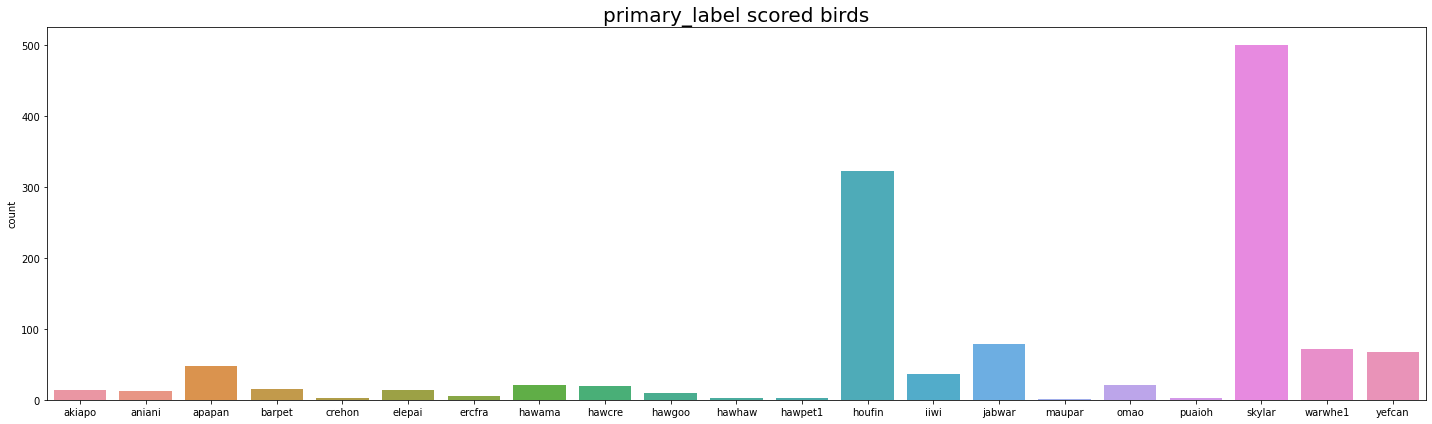

In [32]:
#let's check the primary_label of scored birds

label_row_scored = []
for i in index_row_scored:
    label_row_scored.append(df_train["primary_label"][i])
    

plt.figure(figsize=(20, 6))
sns.countplot(label_row_scored)
plt.title("primary_label scored birds", fontsize=20)

plt.show()

List with the rated audios:

In [33]:

from os import listdir
from os.path import isfile, join
rated_list = []
for i in data:
    onlyfiles = [f for f in listdir("../input/birdclef-2022/train_audio/"+i) if isfile(join("../input/birdclef-2022/train_audio/"+i,f))]
    rated_list.append(i)
    rated_list.append(onlyfiles)
    

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


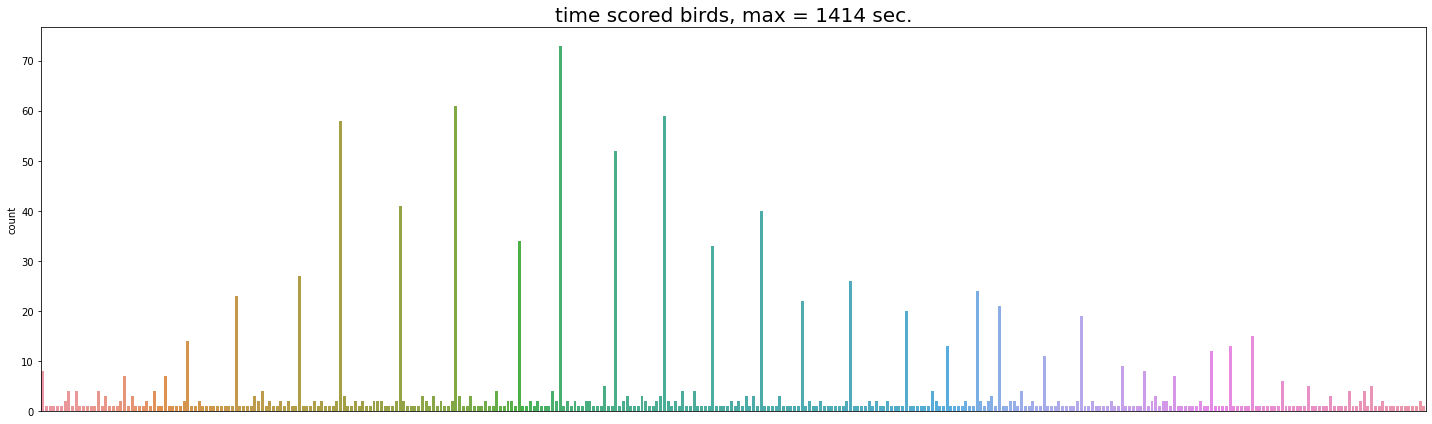

In [34]:
#Distribution of time of each scored audio
#Times goes from 0 to max(time_row_scored)=1414 sec.
counter = 0
time_row_scored = []
for i in index_row_scored:
    counter = counter +1
    if df_train["time"][i][0] not in ["?","x"] and df_train["time"][i][1] not in [":"]:
        time = int(df_train["time"][i][0])*10*60 + int(df_train["time"][i][1])*60 + int(df_train["time"][i][3])*10 +int(df_train["time"][i][4])
        time_row_scored.append(time)
    elif df_train["time"][i][0] not in ["?","x"]:
        time = int(df_train["time"][i][0])*60 + int(df_train["time"][i][2])*10 +int(df_train["time"][i][3])
        time_row_scored.append(time)
        
    
plt.figure(figsize=(20, 6))
sns.countplot(time_row_scored)
plt.title("time scored birds, max = 1414 sec.", fontsize=20)
plt.tick_params(axis = 'x', which = 'both', bottom = False,top = False, labelbottom = False )
plt.xticks(rotation=90)

plt.show()

In [35]:
#Let's calculate how many seconds of audio we have for each scored bird if possible and 
#let save it in a dictionary

counter = 0
time_row_scored = []
for i in index_row_scored:
    counter = counter +1
    if df_train["time"][i][0] not in ["?","x"] and df_train["time"][i][1] not in [":"]:
        time = int(df_train["time"][i][0])*10*60 + int(df_train["time"][i][1])*60 + int(df_train["time"][i][3])*10 +int(df_train["time"][i][4])
        time_row_scored.append(time)
    elif df_train["time"][i][0] not in ["?","x"]:
        time = int(df_train["time"][i][0])*60 + int(df_train["time"][i][2])*10 +int(df_train["time"][i][3])
        time_row_scored.append(time)
    else:
        time_row_scored.append(['Undefined'])


    

In [36]:
from collections import defaultdict
label_row_scored.sort()
outputlist = defaultdict(list)
for A, B in zip(label_row_scored, time_row_scored):
    outputlist[A].append(B)
time_scored_sum = []
for i in data:
    try:
        suma = sum(outputlist[i])
        time_scored_sum.append(suma)
    except:
        time_scored_sum.append(["?"])

In [37]:
dict_species_time = dict(zip(data,time_scored_sum))

In [38]:
dict_species_time

{'akiapo': 11671,
 'aniani': 8360,
 'apapan': 29820,
 'barpet': 18374,
 'crehon': 1157,
 'elepai': 9790,
 'ercfra': 2966,
 'hawama': 15575,
 'hawcre': 15832,
 'hawgoo': 7040,
 'hawhaw': 2373,
 'hawpet1': 3704,
 'houfin': ['?'],
 'iiwi': 23748,
 'jabwar': ['?'],
 'maupar': 738,
 'omao': 11694,
 'puaioh': 2010,
 'skylar': ['?'],
 'warwhe1': ['?'],
 'yefcan': ['?']}

In [39]:
# As there are not so many scored birds, it can be interesting to get spectrograms of 
#high quality audios, and listen those audios while we check the frequencies, intensities, etc
#df_high = df_train
#for i in df_high.index:
    #if df_high['rating'][i]<3.5:
        #df_high.drop([i],axis = 0, inplace = True)

In [40]:
#for j in data:
   # for i in df_high.index:
        #if df_high['primary_label'][i]==j:
            #print(df_high['filename'][i])
#label_row_scored

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


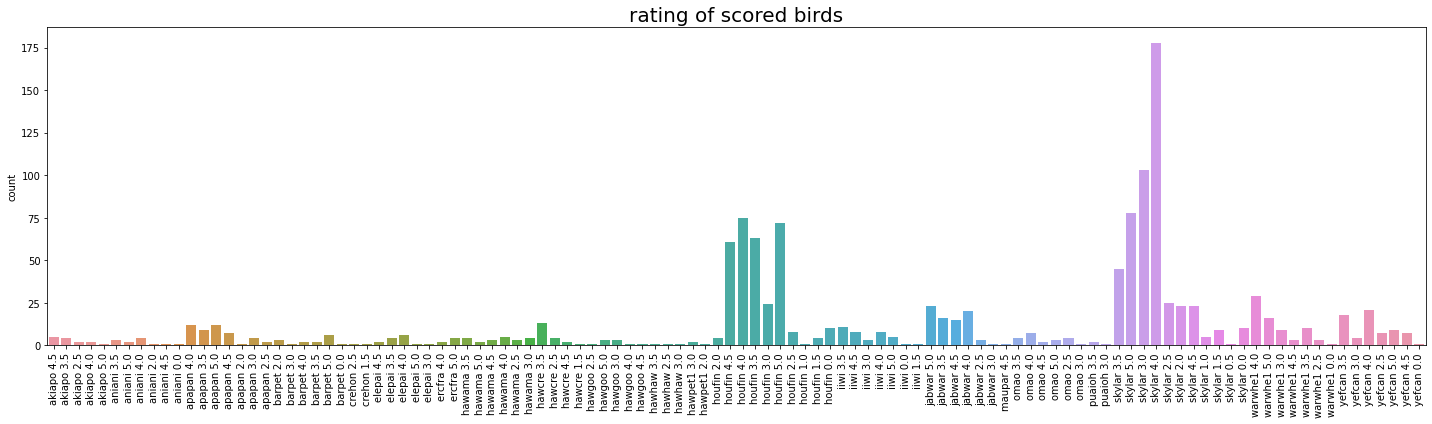

In [41]:
#we can try to find how many audios we have of each scored species and check the rating of
# them, for crehon for example, there are only 2 audios and with low quality.
scoredbird_rating = []
for i in index_row_scored:
    try:
        scoredbird_rating.append(str(df_train['primary_label'][i])+ " " +str(df_train['rating'][i]))
    except:
        print('error')
scoredbird_rating
plt.figure(figsize=(20, 6))
sns.countplot(scoredbird_rating)
plt.xticks(rotation=90)
plt.title("rating of scored birds", fontsize=20)

plt.show()


we can see that for crahon the best rating is 2.5, for puaioh 3.5. there are many species with not so many audios, for example omao, puaioh, crahon...

In [42]:
# with scorebird_rating.index('bird rating') we can localize the index for the best rating of each bird
scoredbird_rating.index('akiapo 5.0')

10

In [43]:
#to find them in the dataset we write the indexes on index_row_scored
index_row_scored[10]

42

In [44]:
print(str(df_train['primary_label'][42]) + ' ' + str(df_train['rating'][42]))

akiapo 5.0


In [45]:
print(str(df_train['filename'][42]))

akiapo/XC306424.ogg


In [46]:
#the list with the indexes like line [80] is

indexes = [10,17,30,78,88,97,105,111,138,152,160,163,175,501,525,603,611,625,629,1129,1205]

In [47]:
#let's get our data from the dataframe
indexes_high_rate = []
for i in indexes:
    indexes_high_rate.append(index_row_scored[i])

print(df_train['primary_label'][indexes_high_rate], df_train['rating'][indexes_high_rate])

    
    

42        akiapo
102       aniani
115       apapan
359       barpet
4302      crehon
4787      elepai
4795      ercfra
6479      hawama
6522      hawcre
6536      hawgoo
6544      hawhaw
6547     hawpet1
6579      houfin
7413        iiwi
7445      jabwar
8721      maupar
10232       omao
11064     puaioh
12896     skylar
14028    warwhe1
14702     yefcan
Name: primary_label, dtype: object 42       5.0
102      5.0
115      5.0
359      5.0
4302     2.5
4787     5.0
4795     5.0
6479     5.0
6522     4.5
6536     5.0
6544     3.5
6547     3.0
6579     5.0
7413     5.0
7445     5.0
8721     4.5
10232    4.5
11064    3.5
12896    5.0
14028    5.0
14702    5.0
Name: rating, dtype: float64


[[ 17260  58119]
 [-60749 -29850]
 [-36259 -11703]
 ...
 [  3738  -1281]
 [ -8997 -17722]
 [ -4334 -12304]]


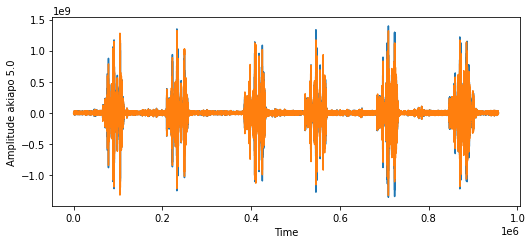

[[   927   9941]
 [-12454 -15278]
 [ 10030 -10508]
 ...
 [ -7186   9405]
 [-17542    569]
 [ -5080  17592]]


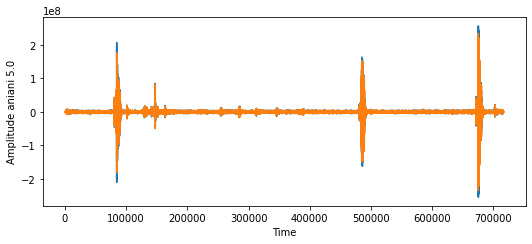

[ -1819   3848 -18640 ... -62915 275534 140544]


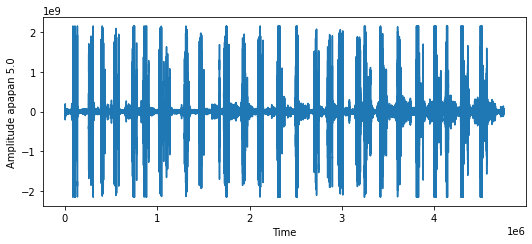

[  -16910   -62685      506 ... 13727468  9767640  7493745]


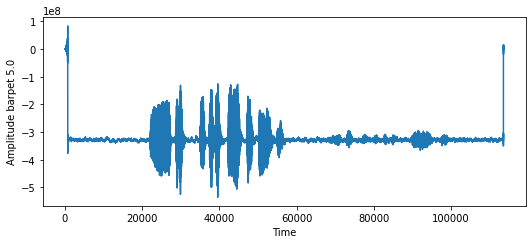

[[  -28242   -62231]
 [  -17075   -46525]
 [  -17517   -55595]
 ...
 [  -30218   482833]
 [-1587246 -1303263]
 [   82822  -854425]]


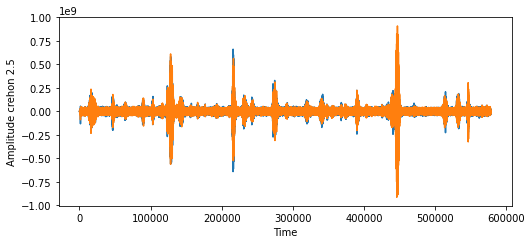

[-5854 -2758 59505 ... -6493  5115   748]


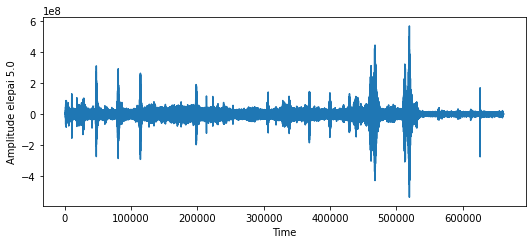

[[-36888  20135]
 [  5908  34487]
 [ 88668  86230]
 ...
 [  5860   9642]
 [  -939  -5628]
 [  -642  -3142]]


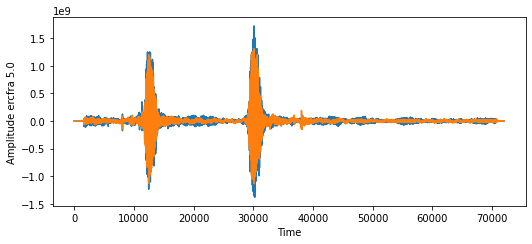

[ -3120  20545  -3630 ...   1816   9858 -13796]


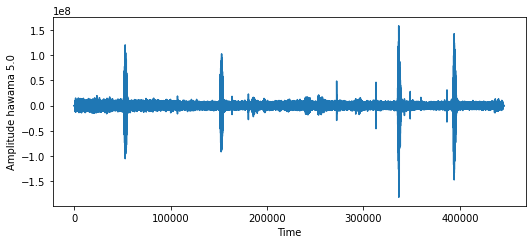

[[-46051 -27246]
 [ 14780  13572]
 [ -1965 -15538]
 ...
 [   308    135]
 [   -76    797]
 [  -123   1205]]


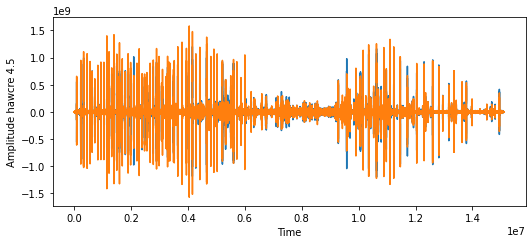

[[   9013    4313]
 [   5013   -9482]
 [  -1363  -27967]
 ...
 [2826039  825901]
 [3429432 1576045]
 [1403199 -399445]]


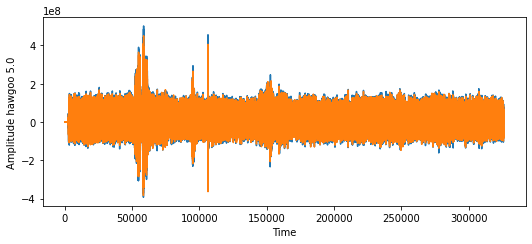

[[ 30256  48111]
 [-22352 -35788]
 [ -2534   -317]
 ...
 [  5456   9414]
 [  5102  32849]
 [ 10403  30032]]


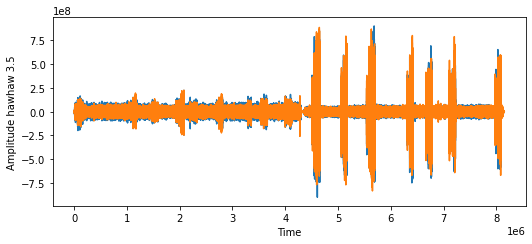

[-77143  -5196 -55581 ...  -1483   -996   -372]


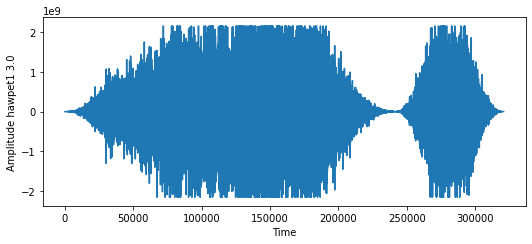

[[ 21564  62117]
 [  9933  47225]
 [-19661   2720]
 ...
 [  9767  21818]
 [ -8778   4490]
 [  -674  15847]]


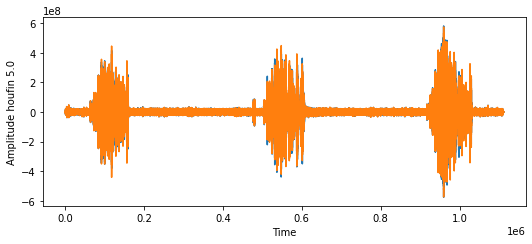

[ 49582   4498 -34531 ...      1     -1      0]


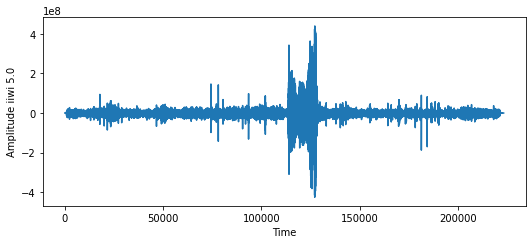

[[  1083 -16321]
 [-23526 -68767]
 [ 29227  -9179]
 ...
 [     2      1]
 [     0     -1]
 [     0      0]]


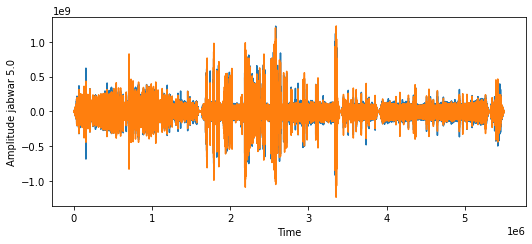

[[ 72769  63875]
 [  2107   5879]
 [-12801  -2098]
 ...
 [-33766 -13556]
 [ -9364  -2932]
 [ 12862  -3401]]


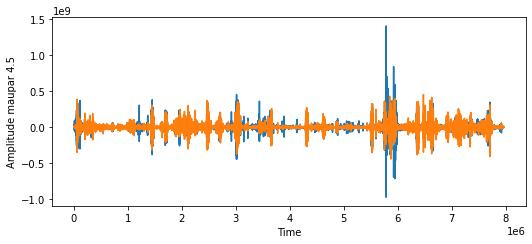

[-5848  2790 -8053 ...   529   194  -928]


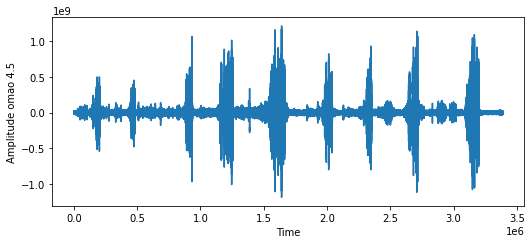

[-59009 -10108  -2232 ...  32570  40716  13963]


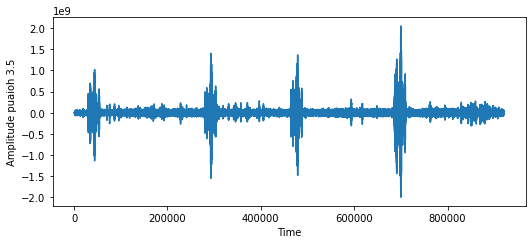

[-6839   613 -6308 ... -2638  2821  2334]


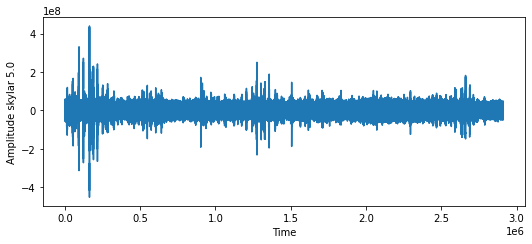

[-16663  70792   7037 ...  -8642  -1834   7962]


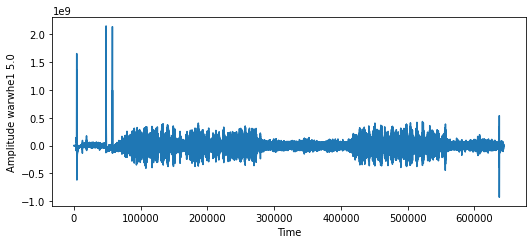

[[  19399   36068]
 [  26892   50328]
 [ -63071  -68410]
 ...
 [-276434 1853790]
 [-279332 1409572]
 [ 207900 1369016]]


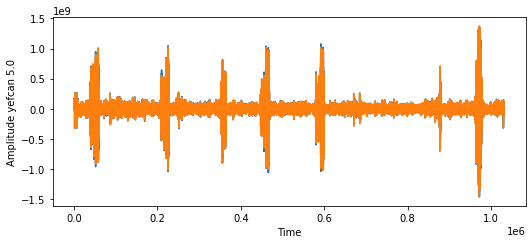

In [48]:
#Let's loop our first code with the random audio but for our list of rated birds
for i in indexes_high_rate:
    src = "../input/birdclef-2022/train_audio/" + str(df_train['filename'][i])
    dst = "/kaggle/working/" + str(df_train['primary_label'][i]) + ".wav"

# convert ogg to wav
    sound = AudioSegment.from_ogg(src)
    sound.export(dst, format="wav")
    
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    input_data = read(dst)
    audio = input_data[1]
    print(audio)
    plt.plot(audio)
    plt.ylabel("Amplitude"+' ' +str(df_train['primary_label'][i]) + ' ' + str(df_train['rating'][i]))
    plt.xlabel("Time")
    plt.show()


In [49]:
#in some cases we have multiple signal. thats because we have stereo and mono audios.

In [50]:
#Let's start MFCC for one of the audios and then apply it to everyone in order to get 
#features of all the audios

data_, sample_rate_ = librosa.load('/kaggle/working/XC395771.wav')
mfccs = librosa.feature.mfcc(y=data_, sr=sample_rate, n_mfcc=40)
print(mfccs.shape)
print(mfccs)


(40, 1174)
[[-7.0985657e+02 -7.0985657e+02 -7.0979950e+02 ... -5.9298932e+02
  -6.5117267e+02 -7.0022858e+02]
 [ 0.0000000e+00  0.0000000e+00 -3.0618386e-02 ...  1.6512424e-02
  -6.8621140e+00 -5.4273896e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.7432774e-02 ... -8.9049683e+01
  -4.7672661e+01 -5.6848841e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00 -7.0810445e-02 ... -1.0322491e+00
  -2.4160979e+00  1.1112320e+00]
 [ 0.0000000e+00  0.0000000e+00  4.3734163e-02 ... -2.3399468e-01
   1.7548532e+00 -2.4952373e-01]
 [ 0.0000000e+00  0.0000000e+00  3.7083797e-02 ... -1.2871429e+00
   2.4797835e+00 -1.6748836e+00]]


In [51]:
#Let's do the same for all the audios
def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features


In [52]:
#Next code works but I will leave it as comment because it takes like 10 hours to get 
# all the features for each audio.
##from tqdm import tqdm
# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients
##extracted_features=[]
##for index_num,row in tqdm(df_train.iterrows()):
    ##file_name = os.path.join(os.path.abspath("../input/birdclef-2022/train_audio/"),str(row["filename"]))
    ##final_class_labels=row["primary_label"]
    ##data=features_extractor(file_name)
    ##extracted_features.append([data,final_class_labels])

In [53]:
#We will use a dataframe with the scored birds just to see that everything works fine 
#without spending so much time
df_scored = df_train.copy()
for i in df_train.index:
    #if df_train['rating'][i]<2.5:
        #df_train.drop([i],axis = 0, inplace = True)
    if i not in index_row_scored:
        df_scored.drop([i],axis = 0, inplace = True)
df_scored

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
32,akiapo,"['apapan', 'hawama', 'iiwi']",['song'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,12:31,https://www.xeno-canto.org/122399,akiapo/XC122399.ogg
33,akiapo,"['apapan', 'iiwi', 'warwhe1']",['call'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,17:46,https://www.xeno-canto.org/122401,akiapo/XC122401.ogg
34,akiapo,['apapan'],['song'],19.6642,-155.3896,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,16:22,https://www.xeno-canto.org/122693,akiapo/XC122693.ogg
35,akiapo,"['apapan', 'elepai', 'hawama', 'iiwi', 'omao',...",['call'],19.6642,-155.3896,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,3.5,15:58,https://www.xeno-canto.org/124705,akiapo/XC124705.ogg
36,akiapo,"['apapan', 'hawama', 'iiwi', 'omao', 'warwhe1']",['song'],19.6334,-155.3753,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,2.5,14:43,https://www.xeno-canto.org/124801,akiapo/XC124801.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14758,yefcan,[],"['adult', 'sex uncertain', 'song']",-33.1801,26.4388,Crithagra mozambica,Yellow-fronted Canary,Lynette Rudman,Creative Commons Attribution-NonCommercial-Sha...,4.0,12:30,https://www.xeno-canto.org/638431,yefcan/XC638431.ogg
14759,yefcan,[],"['adult', 'mimicry/imitation', 'sex uncertain'...",-33.1777,26.4534,Crithagra mozambica,Yellow-fronted Canary,Lynette Rudman,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/638457,yefcan/XC638457.ogg
14760,yefcan,[],"['adult', 'male', 'mimicry/imitation', 'song']",-32.9558,26.4039,Crithagra mozambica,Yellow-fronted Canary,Lynette Rudman,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/648484,yefcan/XC648484.ogg
14761,yefcan,[],"['adult', 'sex uncertain', 'song']",-33.0433,26.4463,Crithagra mozambica,Yellow-fronted Canary,Lynette Rudman,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:30,https://www.xeno-canto.org/664188,yefcan/XC664188.ogg


In [54]:
#Let's see if we get more accuracy when we drop elements with less than 2.5 rating
#for i in df_scored.index:
   # if df_scored['rating'][i]<2.5:
        #df_scored.drop([i],axis = 0, inplace = True)

In [55]:
#We will use a method that stract features from the audios
from tqdm import tqdm
# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(df_scored.iterrows()):
    file_name = os.path.join(os.path.abspath("../input/birdclef-2022/train_audio/"),str(row["filename"]))
    final_class_labels=row["primary_label"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

1266it [12:15,  1.72it/s]


In [56]:
len(extracted_features)

1266

In [57]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','primary_label'])
extracted_features_df.head()

,feature,primary_label
0,"[-472.28574, 60.7976, -25.217098, 57.126324, 1...",akiapo
1,"[-446.27298, 55.930138, -19.547518, 57.774445,...",akiapo
2,"[-266.47318, 75.57892, -7.943713, 50.27808, -4...",akiapo
3,"[-404.56955, 26.65804, -27.88428, 29.090647, -...",akiapo
4,"[-381.15158, 27.375917, -63.842342, 60.094864,...",akiapo


In [58]:
#Now we split the data into train and test
from imblearn.over_sampling import RandomOverSampler #we improved accuracy with this!
oversample = RandomOverSampler(sampling_strategy='minority')
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['primary_label'].tolist())
# Label Encoding -> Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
from sklearn.model_selection import train_test_split
#X,y = oversample.fit_resample(X, y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [59]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
# No of classes
num_labels=y.shape[1]

In [61]:

#import numpy as np
#import matplotlib.pyplot as plt

#from sklearn import svm, datasets
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import ConfusionMatrixDisplay

#classifier = svm.SVC(kernel="linear", C=0.01).fit(X_train, y_train)

#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#titles_options = [
    #("Confusion matrix, without normalization", None),
    #("Normalized confusion matrix", "true"),
#]

#for title, normalize in titles_options:
   # disp = ConfusionMatrixDisplay.from_estimator(
        #classifier,
       # X_test,
        #y_test,
        #cmap=plt.cm.Blues,
        #normalize=normalize,
    #)
    #disp.ax_.set_title(title)

    #print(title)
    #print(disp.confusion_matrix)

#plt.show()

In [62]:

model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

2022-05-01 19:22:04.630972: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [63]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [64]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 200
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

2022-05-01 19:22:08.120281: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
32/32 [==============================] - 1s 14ms/step - loss: 38.7029 - accuracy: 0.1848 - val_loss: 4.9670 - val_accuracy: 0.3740

Epoch 00001: val_loss improved from inf to 4.96698, saving model to ./audio_classification.hdf5
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 16.0335 - accuracy: 0.2055 - val_loss: 2.7998 - val_accuracy: 0.3740

Epoch 00002: val_loss improved from 4.96698 to 2.79979, saving model to ./audio_classification.hdf5
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 9.1801 - accuracy: 0.2095 - val_loss: 2.2416 - val_accuracy: 0.3701

Epoch 00003: val_loss improved from 2.79979 to 2.24161, saving model to ./audio_classification.hdf5
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 6.5249 - accuracy: 0.2174 - val_loss: 2.4239 - val_accuracy: 0.3701

Epoch 00004: val_loss did not improve from 2.24161
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 4.9879 - 

In [65]:
model.predict(X_test)[0]

array([0.06403209, 0.01802173, 0.07614385, 0.00840263, 0.00926756,
       0.04205214, 0.01110856, 0.05054381, 0.06924423, 0.01493958,
       0.010947  , 0.00616293, 0.09817977, 0.07631696, 0.10960852,
       0.00394157, 0.06240795, 0.00615952, 0.13504496, 0.05359754,
       0.07387723], dtype=float32)

To fully understand what we are doing and change our code propperly we will make a little explanation

In [66]:
y = np.array(extracted_features_df['primary_label'].tolist())

In [67]:
y

array(['akiapo', 'akiapo', 'akiapo', ..., 'yefcan', 'yefcan', 'yefcan'],
      dtype='<U7')

we our dataset getting x and y being x the feature column and y the prymary label column

In [68]:
labelencoder.fit_transform(y)

array([ 0,  0,  0, ..., 20, 20, 20])

we trnasform into an array with the  names as numbers

In [69]:
y = to_categorical(labelencoder.fit_transform(y))

In [70]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

now our y is an array of arrais. In first array we see, that the  first element is 1, that means the first kind (akiapo), the second array is the same because for the next audio we have the same bird(akiapo). so this is refered to the audios and the kind of bird we have

In [71]:
X = np.array(extracted_features_df['feature'].tolist())

In [72]:
X

array([[-4.7228574e+02,  6.0797600e+01, -2.5217098e+01, ...,
         3.9525729e-01, -3.2604110e-01, -2.3376600e-01],
       [-4.4627298e+02,  5.5930138e+01, -1.9547518e+01, ...,
         4.4190086e-02,  1.8309697e+00, -6.5673167e-01],
       [-2.6647318e+02,  7.5578918e+01, -7.9437132e+00, ...,
         3.3829150e-01, -1.8323116e-01,  1.2328384e+00],
       ...,
       [-5.6030518e+02, -2.8958155e+01,  1.1890236e+01, ...,
         1.6775605e-01,  8.1823599e-01, -8.4031865e-02],
       [-4.8196133e+02,  9.3748230e+01,  7.7095919e+00, ...,
        -2.3456349e+00, -2.3804078e+00, -6.0837263e-01],
       [-4.6107327e+02,  2.0937910e+01, -2.7872059e+01, ...,
        -1.6457257e-01, -1.6375295e+00, -1.7106326e-01]], dtype=float32)

For X we have the list of audios with the features. first string we see is associated to the first audios and the number with commmas are the features of such audio

In [73]:
#X,y = oversample.fit_resample(X,y)

In [74]:
X.shape

(1266, 40)

we have increase the number of samples in order to change accuracy

In [75]:
X_test.shape
X_train.shape
X.shape

(1266, 40)

We got 20 per cent of the samples for X_test and 80 per cent for X_train . the same for y

In [76]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [77]:
y_test.shape

(254, 21)

In [78]:

# Let's check the accuracy!
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.5472440719604492


In [79]:
model.conf = 0.25

In [80]:
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis = 1)
predict_x[1]

array([3.5397413e-03, 6.0271524e-04, 2.1814078e-02, 6.8239890e-02,
       1.1189828e-03, 4.8622701e-02, 9.2129909e-02, 2.0038690e-03,
       5.9234453e-03, 5.7472237e-03, 8.8655355e-04, 9.1773588e-03,
       1.6513152e-01, 7.7658286e-03, 1.9126068e-01, 1.4663757e-04,
       4.9647588e-02, 3.5659146e-02, 7.8736104e-02, 4.0479716e-02,
       1.7136627e-01], dtype=float32)

We have improve from the accuracy from 0.43 to 0.58 just using RandomOverSampler in categorical cross entropy loss :D. I tried others like SMOTE but I got errors because there is a class with just 2 samples and n_samples must be > n_labels with those algorithms. We get accuracy of 0.53 with poisson loss. 0.54 for KLDivergence loss. 0.56 for binary cross entropy loss. 0.65 for MeanSquaredError. 0.66 for MeanAbsoluteError. 0.65 for MeanAbsolutePercentageError. 0.62 for MeanSquaredLogarithmicError. 0.65 for huber. 0.65 for LogCosh. 0.66 for Hinge. 0.66 for SquaredHinge. 0.63 for CategoricalHinge.
We have improved accuracy again :D. 

It looks like the accuracy depends a lot with tne random oversample, so each time we train the neural network we will get different accuracy for the same loss. It is important to find the best oversample and save it.

In [81]:
#Let's see how to submit our results
#filename = 
#audio, sample_rate = librosa.load(filename, res_type = 'kaiser_fast')
#mfcc_features = librosa.load(y = audio, sr = sample_rate,n_mfcc = 40)
#mfccs_scaled_features = np.mean(mfccs_features.T,axis = 0)

#mfcc_scaled_features = mfcc

In [82]:
test_audio_dir = '../input/birdclef-2022/test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(test_audio_dir))]

In [83]:
print('Number of test soundscapes:', len(file_list))

Number of test soundscapes: 1


In [84]:
with open('../input/birdclef-2022/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [85]:
pred = {'row_id': [], 'target': []}

In [86]:
# Process audio files and make predictions
for afile in file_list:
    
    # Complete file path
    path = test_audio_dir + afile + '.ogg'
    
    # Open file with librosa and split signal into 5-second chunks
    # sig, rate = librosa.load(path)
    # ...
    
    # Let's assume we have a list of 12 audio chunks (1min / 5s == 12 segments)
    chunks = [[] for i in range(12)]

In [87]:
chunks

[[], [], [], [], [], [], [], [], [], [], [], []]

In [88]:
# to check our prediction, those are the strings we need to compare:
a = 0
for i in range(len(y_test)):
    if str(y_test[i])==str(predict_x[i]).replace(".", ""):
        a=a+1
print(a)
print(a/len(y_test))

0
0.0


In [89]:
y_test.shape
predict_x.shape
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#score = f1_score(str(y_test[1]),str(predict_x[1]).replace(".", ""), average = None)
#fil_acc_orig = accuracy_score(X_test,predict_x)

X_test

y



array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's prepare the test file to create the submision csv

In [90]:
# we will divide the test audio in 12 audios of 5 seconds.

from pydub import AudioSegment
from pydub.utils import make_chunks 
sound = AudioSegment.from_file("../input/birdclef-2022/test_soundscapes/soundscape_453028782.ogg")

chunk_length_ms = 5000 # pydub calculates in millisec 
chunks = make_chunks(sound,chunk_length_ms) #Make chunks of one sec 
for i, chunk in enumerate(chunks): 
    chunk_name = "{0}.ogg".format(i) 
    print ("exporting", chunk_name) 
    chunk.export(chunk_name, format="ogg") 


exporting 0.ogg
exporting 1.ogg
exporting 2.ogg
exporting 3.ogg
exporting 4.ogg
exporting 5.ogg
exporting 6.ogg
exporting 7.ogg
exporting 8.ogg
exporting 9.ogg
exporting 10.ogg
exporting 11.ogg


In [91]:
# Lets stract the features
import librosa
import numpy as np

def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features


import os
extracted_features_=[]
for i in range(0,12):
    file_name = os.path.join(os.path.abspath("./"),str(i) + ".ogg")
    data=features_extractor(file_name)
    extracted_features_.append([data])

In [92]:
len(extracted_features_)

12

In [93]:
import pandas as pd
extracted_features_df_=pd.DataFrame(extracted_features_,columns=['feature'])

In [94]:
X_=np.array(extracted_features_df_['feature'].tolist())
X_.shape

(12, 40)

In [95]:
with open('../input/birdclef-2022/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [96]:
scored_birds_ = to_categorical(labelencoder.fit_transform(scored_birds))

In [97]:
scored_birds_

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

In [98]:
len(scored_birds)

21

In [99]:
score = []
scored_birds_.tolist()
predict_x.tolist()
for i in range(len(scored_birds_)):
    for j in range(len(predict_x)):
        if str(scored_birds_[i]).replace(".", "") == str(predict_x[j]).replace(".", ""):
            score.append(scored_birds[i])
print(score)


[]


In [100]:
predict__=model.predict(X_)

In [101]:
# This is where we will store our results
pred = {'row_id': [], 'target': []}

# Process audio files and make predictions
for afile in file_list:
    
    # Complete file path
    path = test_audio_dir + afile + '.ogg'
    
    # Open file with librosa and split signal into 5-second chunks
    # sig, rate = librosa.load(path)
    # ...
    
    # Let's assume we have a list of 12 audio chunks (1min / 5s == 12 segments)
    chunks = [[] for i in range(12)]
    
    # Make prediction for each chunk
    # Each scored bird gets a random value in our case
    # since we don't actually have a model
    for i in range(len(chunks)):        
        chunk_end_time = (i + 1) * 5
        j=0
        for bird in scored_birds:
            
            # This is our random prediction score for this bird
            score = predict__[i][j]
            j=j+1
            # Assemble the row_id which we need to do for each scored bird
            row_id = afile + '_' + bird + '_' + str(chunk_end_time)
            
            # Put the result into our prediction dict and
            # apply a "confidence" threshold of 0.5
            pred['row_id'].append(row_id)
            pred['target'].append(True if score > 0.5 else False)

In [102]:
pred

{'row_id': ['soundscape_453028782_akiapo_5',
  'soundscape_453028782_aniani_5',
  'soundscape_453028782_apapan_5',
  'soundscape_453028782_barpet_5',
  'soundscape_453028782_crehon_5',
  'soundscape_453028782_elepai_5',
  'soundscape_453028782_ercfra_5',
  'soundscape_453028782_hawama_5',
  'soundscape_453028782_hawcre_5',
  'soundscape_453028782_hawgoo_5',
  'soundscape_453028782_hawhaw_5',
  'soundscape_453028782_hawpet1_5',
  'soundscape_453028782_houfin_5',
  'soundscape_453028782_iiwi_5',
  'soundscape_453028782_jabwar_5',
  'soundscape_453028782_maupar_5',
  'soundscape_453028782_omao_5',
  'soundscape_453028782_puaioh_5',
  'soundscape_453028782_skylar_5',
  'soundscape_453028782_warwhe1_5',
  'soundscape_453028782_yefcan_5',
  'soundscape_453028782_akiapo_10',
  'soundscape_453028782_aniani_10',
  'soundscape_453028782_apapan_10',
  'soundscape_453028782_barpet_10',
  'soundscape_453028782_crehon_10',
  'soundscape_453028782_elepai_10',
  'soundscape_453028782_ercfra_10',
  'so

In [103]:
# from sklearn.metrics import f1_score
#f1_score(y_true, y_pred, average=None)

In [104]:
#Of course it is not a good way to solve the problem, we did our data analisys for something
# and the code will be of course improved. We need to use data from all the birds, consider
# the rating, etc
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [105]:
#Let's see how important are the audios with 0.o rating
count = 0
print(len(df_train))
for i in range(len(df_train)):
    if df_train['rating'][i] == 0.0:
        count = count +1
        print(df_train['primary_label'][i],df_train['time'][i])
print(count)

14852
amewig 12:49
amewig 12:51
amewig 13:14
aniani 15:00
arcter 10:00
arcter 10:00
arcter 10:00
arcter 11:00
arcter 11:00
arcter 11:00
arcter 11:00
arcter 11:00
arcter 11:00
arcter 11:00
arcter 12:00
arcter 12:00
arcter 12:00
arcter 12:00
arcter 18:00
arcter 18:00
arcter 18:00
arcter 18:00
arcter 18:00
arcter 18:00
arcter 23:00
arcter 06:00
arcter 06:00
arcter 13:00
arcter 19:30
barpet 23:30
bcnher 01:25
belkin1 13:38
belkin1 13:39
belkin1 13:58
belkin1 18:21
belkin1 13:08
bkbplo 02:30
bkbplo 00:00
bkbplo 02:00
bkbplo 17:30
bkbplo 01:30
bkbplo 15:00
bkbplo 02:00
bknsti 10:00
bknsti 08:00
bknsti 09:00
bknsti 08:31
bknsti 06:00
bknsti 06:00
bknsti 06:00
bknsti 07:30
bknsti 10:00
blkfra 17:30
blkfra 08:00
bongul 22:30
bongul 13:55
brant 01:00
brant 03:00
brant 00:00
brant 08:00
brant 09:00
brant 14:00
brant 23:30
brant 02:32
brant 22:00
brnowl 20:30
brnowl 23:00
brnowl 02:00
brnowl 02:00
brnowl 22:00
brnowl 20:15
brnowl 22:30
brnowl 19:24
brnowl 18:07
brnowl 02:15
brnowl 00:00
brnowl 02:

In [106]:
#Let's check the duration of the unescored audios and see if those are very important factors
#in our analysis.
count = 0
print(len(df_scored))
for i in index_row_scored:
    if df_scored['rating'][i] == 0.0:
        count = count+1
        print(df_scored['primary_label'][i],df_scored['time'][i])
print(count)

1266
aniani 15:00
barpet 23:30
houfin 10:25
houfin 14:09
houfin 09:24
houfin 15:03
houfin 12:26
houfin 12:21
houfin 08:00
houfin 10:24
houfin 10:23
houfin 09:49
iiwi 11:00
skylar 15:00
skylar 00:00
skylar 08:15
skylar 12:27
skylar 08:30
skylar 10:54
skylar 12:00
skylar 02:30
skylar 04:30
skylar 04:46
warwhe1 08:55
yefcan 10:30
25


In [107]:
count = 0
print(len(df_scored))
for i in index_row_scored:
    print(df_scored['primary_label'][i],df_scored['time'][i])
    count = count+1

print(count)

1266
akiapo 12:31
akiapo 17:46
akiapo 16:22
akiapo 15:58
akiapo 14:43
akiapo 15:00
akiapo 16:56
akiapo 15:40
akiapo 13:30
akiapo 14:00
akiapo 12:00
akiapo 11:05
akiapo 08:30
akiapo 10:30
aniani 09:30
aniani 10:00
aniani 10:30
aniani 15:30
aniani 09:00
aniani 09:00
aniani 11:30
aniani 15:00
aniani 11:30
aniani 10:50
aniani 15:00
aniani 12:00
apapan 09:30
apapan 09:30
apapan 06:00
apapan 06:00
apapan 06:30
apapan 06:30
apapan 12:00
apapan 12:00
apapan 15:00
apapan 15:00
apapan 09:00
apapan 09:00
apapan 09:00
apapan 17:00
apapan 13:30
apapan 10:30
apapan 07:30
apapan 10:00
apapan 13:45
apapan 09:45
apapan 12:00
apapan 12:45
apapan 11:45
apapan 12:00
apapan 06:15
apapan 10:00
apapan 13:10
apapan 09:30
apapan 07:33
apapan 07:37
apapan 08:08
apapan 09:03
apapan 06:21
apapan 06:22
apapan 13:30
apapan 12:00
apapan 06:43
apapan 11:58
apapan 16:46
apapan 16:22
apapan 11:53
apapan 12:04
apapan 06:59
apapan 07:01
apapan 17:37
apapan 16:38
apapan 08:00
barpet 23:08
barpet 23:17
barpet 21:00
barpet 

In [108]:
# The unrated audios doesn't look like very important data, those have average duration and
# there are not so many of them, and are not present in the birds with too less audios.
# We will drop them for now.

In [109]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier(random_state=0)
cls.fit(X_train, y_train)

z = cls.predict_proba(X_test)

In [110]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [111]:


predict_prob=model.predict(X_test)

predict_classes=np.argmax(predict_prob,axis=1)

predict_prob

clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))

In [112]:
y_train_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
y_train_ = np.asarray(y_train_)
y_train_.shape
X_train.shape
k=np.array(extracted_features_df['primary_label'].tolist())
k = labelencoder.fit_transform(k)

In [113]:
clf.fit(X, k)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [114]:
print(clf.named_steps['linearsvc'].coef_)

[[-2.13455676e-02  9.62739640e-02 -4.51608227e-02  1.16365460e-01
   1.01739657e-01 -4.67610220e-02  3.58812633e-02  3.07439705e-02
  -4.01861613e-02 -2.11034834e-02 -6.53015359e-02  1.01943991e-01
  -2.11002835e-02 -2.22909113e-03  3.88013985e-02 -3.49688971e-02
  -1.41164334e-01  6.14372736e-02 -1.76202532e-02  3.69116569e-02
  -4.90829399e-02  4.21294691e-02  8.96002775e-03 -1.30920829e-01
   6.09656199e-02 -1.89406975e-02 -1.06995432e-01  3.37064963e-02
   1.59984017e-01  3.41068150e-02  1.06501224e-01  8.65720745e-02
  -2.96101039e-02 -5.95583277e-02  1.66369601e-02 -7.46388528e-02
   2.06361345e-02 -5.29806230e-03 -3.50647202e-02  5.19857618e-03]
 [-8.99982911e-02  8.64338806e-02 -2.24152879e-02  2.59970353e-02
  -1.52202853e-02  3.23934747e-02 -1.25818560e-01 -2.17645649e-02
   4.16436140e-02 -2.03183134e-02 -5.25550284e-02  8.25213145e-02
   1.20331376e-02  2.82283386e-03  1.69167553e-02  5.63292459e-02
  -1.10108530e-01 -1.07152644e-03 -2.54719594e-02  2.36323255e-02
   1.7966

In [115]:
print(clf.named_steps['linearsvc'].intercept_)

[-1.24155873 -1.20533659 -1.0632264  -2.39492741 -1.23057718 -1.06630458
 -2.61320105 -1.39996528 -1.25634337 -2.06999891 -2.23120251 -1.92164581
 -0.59301753 -0.98744629 -1.06129307 -1.60555638 -1.08879734 -2.23053739
 -0.23789765 -1.16762352 -0.95549275]


In [116]:
pre = clf.score(X,k)
pre

0.6334913112164297

In [117]:
prediction = clf.decision_function(X)

In [118]:
prediction

array([[-0.0936412 , -0.94860796, -0.52653087, ..., -0.99029639,
        -1.60163736, -0.98063812],
       [-0.44250212, -0.94970365, -1.14092095, ..., -0.50315261,
        -1.44388028, -1.06139593],
       [-0.62559708, -1.35231932, -1.34407378, ..., -0.22586764,
        -1.17681548, -0.95141408],
       ...,
       [-1.57374386, -0.9372416 , -0.91401725, ...,  0.03868258,
        -1.01679444, -0.23863435],
       [-1.42035468, -1.16249391, -1.08406897, ..., -0.23359995,
        -1.60469067, -0.92511746],
       [-1.52981501, -1.25312332, -1.13214621, ...,  0.20546814,
        -1.16811694, -0.70855478]])

In [119]:
print(prediction[0])
max_ = []
for i in range(len(prediction)):
    print(prediction[i])

    

[-0.0936412  -0.94860796 -0.52653087 -1.80100639 -0.90784594 -1.12258768
 -1.42967214 -1.03441544 -0.4584978  -1.33234449 -1.34752111 -2.34063304
 -1.06159588 -0.84425248 -1.47039058 -1.85180838 -0.87932382 -1.77479153
 -0.99029639 -1.60163736 -0.98063812]
[-0.0936412  -0.94860796 -0.52653087 -1.80100639 -0.90784594 -1.12258768
 -1.42967214 -1.03441544 -0.4584978  -1.33234449 -1.34752111 -2.34063304
 -1.06159588 -0.84425248 -1.47039058 -1.85180838 -0.87932382 -1.77479153
 -0.99029639 -1.60163736 -0.98063812]
[-0.44250212 -0.94970365 -1.14092095 -3.41530162 -1.12576368 -1.2294689
 -1.33867734 -1.32449562 -0.5564652  -1.98718223 -2.10131616 -2.00352898
 -0.01913714 -0.94951005 -1.54285938 -1.87535496 -1.04767109 -2.60054808
 -0.50315261 -1.44388028 -1.06139593]
[-0.62559708 -1.35231932 -1.34407378 -2.48249024 -0.96774675 -0.85678117
 -2.38526823 -1.31268822 -0.88611108 -2.4110762  -1.5594172  -1.60605076
 -0.776649   -0.96706294 -0.61584257 -1.70995832 -0.93252506 -1.63909701
 -0.2258676

In [120]:
results = pd.DataFrame(pred, columns = ['row_id', 'target'])

# Quick sanity check
print(results.head()) 
    
# Convert our results to csv
results.to_csv("submission.csv", index=False)

                          row_id  target
0  soundscape_453028782_akiapo_5   False
1  soundscape_453028782_aniani_5   False
2  soundscape_453028782_apapan_5   False
3  soundscape_453028782_barpet_5   False
4  soundscape_453028782_crehon_5   False
